# Dogs vs. Cats
## Create an algorithm to distinguish dogs from cats

In this competition, we write an algorithm to classify whether images contain either a dog or a cat. 

**Data Description:**

The train folder contains 25,000 images of dogs and cats. Each image in this folder has the label as part of the filename. The test folder contains 12,500 images, named according to a numeric id. For each image in the test set, we need to predict a probability that the image is a dog (1 = dog, 0 = cat)

We start by importing relevant libraries. We mainly use tensorflow to implement all the algorithms.

In [1]:
#import statements
import warnings
warnings.filterwarnings('ignore')
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import cv2
import numpy as np
import pandas as pd
np.random.seed(42)

import sys
from matplotlib import pyplot
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import applications
from tensorflow.keras.applications import InceptionV3


We start by unzipping our images.

In [2]:
!unzip -q /kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
!unzip -q /kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip

## Model Exploration

We start exploring models in this section. The below code snippet creates a directory structure which contains images in their respective class folders.

In [3]:
# organize dataset into a useful structure
# create directories
dataset_home = '/kaggle/working/sg/'
subdirs = ['train/', 'val/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = '/kaggle/working/train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    dst_dir = 'train/'
    if random() < val_ratio:
        dst_dir = 'val/'
    if file.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/'  + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/'  + file
        copyfile(src, dst)

Here, we define a function which is used to plot learning curves, so that we can check our training and validation accuracy.

In [4]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.figure(figsize=(7, 15))
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    pyplot.legend(loc='upper right')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    pyplot.legend(loc='upper right')
    pyplot.show()

This function is used for the following tasks:
1. Generate training and validation datasets using tensorflow's datagenerator flow_from_directory
2. Implement early stopping to try and prevent overfitting
3. Fit the model defined by the define_model function.
4. Evalute the same using the validation dataset.

In [5]:
# run the test harness for evaluating a model
#implementing early stopping in this code
def run_test_harness():
 # define model
    model = define_model()

    # create data generator
    datagen = ImageDataGenerator(featurewise_center=True)

    # specify imagenet mean values for centering
    datagen.mean = [123.68, 116.779, 103.939]

    # prepare iterator
    train_it = datagen.flow_from_directory('/kaggle/working/sg/train/',
    class_mode='binary', batch_size=64, target_size=(224, 224))
    test_it = datagen.flow_from_directory('/kaggle/working/sg/val/',
    class_mode='binary', batch_size=64, target_size=(224, 224))

    # callback for early stopping
    callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)
    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it),
                         validation_data=test_it, 
                         validation_steps=len(test_it), 
                         epochs=50, verbose=1,
                         callbacks=[callback])
    # evaluate model
    _, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
    print('> %.3f' % (acc * 100.0))
    # plot learning curves
    summarize_diagnostics(history)
return(history)

Below is a model definition of a 3 layer VGG. We define this model using define_model() function and then fit the same using functions created above. We see we get an accuacy of 75% using this model.

2022-12-04 12:45:02.632859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 12:45:02.765037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 12:45:02.765863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 12:45:02.767944: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


2022-12-04 12:45:07.750598: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-04 12:45:09.957713: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


293/293 [==============================] - 159s 516ms/step - loss: 68.5767 - accuracy: 0.5319 - val_loss: 0.6946 - val_accuracy: 0.5023
Epoch 2/50
293/293 [==============================] - 142s 484ms/step - loss: 0.6899 - accuracy: 0.5497 - val_loss: 0.6845 - val_accuracy: 0.5520
Epoch 3/50
293/293 [==============================] - 140s 478ms/step - loss: 0.6783 - accuracy: 0.5763 - val_loss: 0.6711 - val_accuracy: 0.5999
Epoch 4/50
293/293 [==============================] - 140s 478ms/step - loss: 0.6734 - accuracy: 0.5807 - val_loss: 0.6691 - val_accuracy: 0.5970
Epoch 5/50
293/293 [==============================] - 141s 483ms/step - loss: 0.6716 - accuracy: 0.5920 - val_loss: 0.6639 - val_accuracy: 0.6013
Epoch 6/50
293/293 [==============================] - 143s 487ms/step - loss: 0.6672 - accuracy: 0.5958 - val_loss: 0.6566 - val_accuracy: 0.5970
Epoch 7/50
293/293 [==============================] - 140s 477ms/step - loss: 0.6633 - accuracy: 0.5977 - val_loss: 0.6484 - val_accur

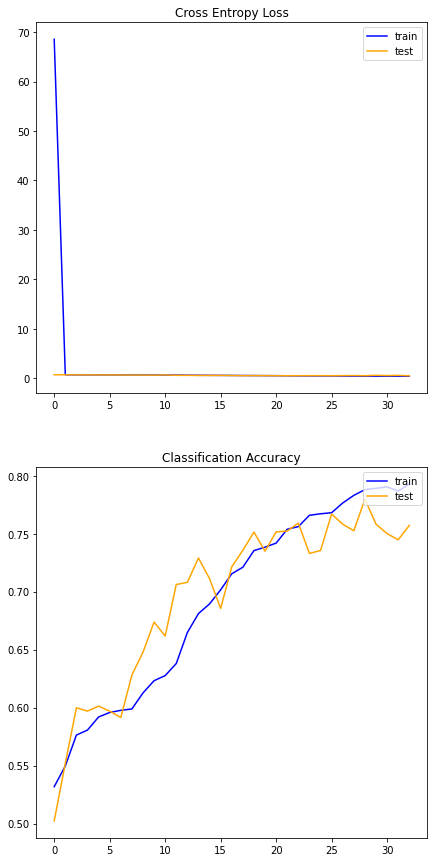

In [6]:
# 3 layer sequential model with dropout
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', 
                     kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

history = run_test_harness()

We now explore **Transfer Learning** models. Transfer Learning partially resolves the limitations of the isolated learning paradigm:

"The current dominant paradigm for ML is to run an ML algorithm on a given dataset to generate a model. The model is then applied in real-life tasks. We call this paradigm isolated learning because it does not consider any other related information or the knowledge learned in the past." (Liu, 2016)

Transfer Learning gives us the ability to share learned features across different learning tasks. Transfer learning involves using all or parts of a model trained on a related task. Keras provides a range of pre-trained models that can be loaded and used wholly or partially via the Keras Applications API.

The below code implements a VGG-16, and achieves an accuracy of around 97%. We overwrite our previous define_model() function to code for our new model.

58900480/58889256 [==============================] - 0s 0us/step
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/50
293/293 [==============================] - 155s 512ms/step - loss: 0.7883 - accuracy: 0.9451 - val_loss: 0.0903 - val_accuracy: 0.9710
Epoch 2/50
293/293 [==============================] - 144s 492ms/step - loss: 0.0929 - accuracy: 0.9702 - val_loss: 0.1324 - val_accuracy: 0.9619
Epoch 3/50
293/293 [==============================] - 146s 499ms/step - loss: 0.0814 - accuracy: 0.9757 - val_loss: 0.0960 - val_accuracy: 0.9746
Epoch 4/50
293/293 [==============================] - 146s 498ms/step - loss: 0.0555 - accuracy: 0.9819 - val_loss: 0.0917 - val_accuracy: 0.9737
Epoch 5/50
293/293 [==============================] - 146s 500ms/step - loss: 0.0524 - accuracy: 0.9818 - val_loss: 0.0850 - val_accuracy: 0.9752
Epoch 6/50
293/293 [==============================] - 146s 499ms/step - loss: 0.0451 - accuracy: 0.9855 - val_loss: 0.10

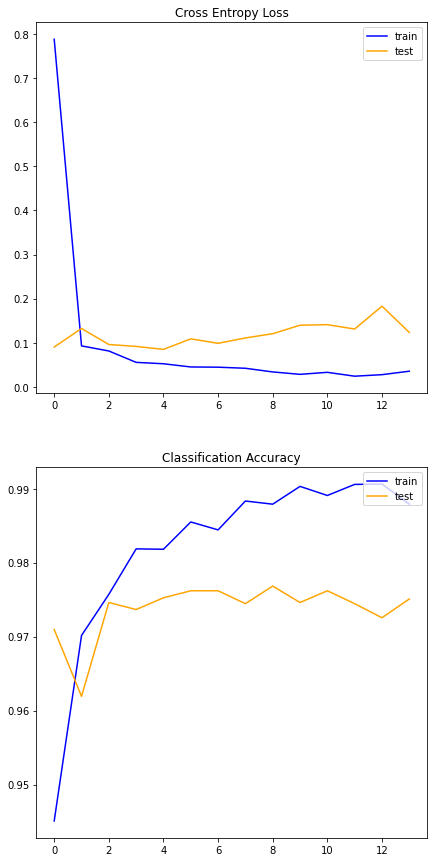

In [7]:
# vgg16 model used for transfer learning on the dogs and cats dataset
# define cnn model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False

    flat = Flatten()(model.layers[-1].output)
    classification = Dropout(0.5)(Dense(128, activation='relu', kernel_initializer='he_uniform')(flat))
    output = Dense(1, activation='sigmoid')(classification)

    model = Model(inputs=model.inputs, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# entry point, run the test harness
history = run_test_harness()

We also look at resnet-50, another transfer learning algorithm. We again overwrite our define_model() function to implement the same. The accuracy with resnet is around 98.5%.

94781440/94765736 [==============================] - 0s 0us/step
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/50
293/293 [==============================] - 151s 505ms/step - loss: 0.0776 - accuracy: 0.9709 - val_loss: 0.0463 - val_accuracy: 0.9849
Epoch 2/50
293/293 [==============================] - 145s 495ms/step - loss: 0.0454 - accuracy: 0.9844 - val_loss: 0.0481 - val_accuracy: 0.9827
Epoch 3/50
293/293 [==============================] - 145s 497ms/step - loss: 0.0385 - accuracy: 0.9857 - val_loss: 0.0526 - val_accuracy: 0.9794
Epoch 4/50
293/293 [==============================] - 145s 496ms/step - loss: 0.0307 - accuracy: 0.9890 - val_loss: 0.0509 - val_accuracy: 0.9824
Epoch 5/50
293/293 [==============================] - 147s 502ms/step - loss: 0.0240 - accuracy: 0.9913 - val_loss: 0.0741 - val_accuracy: 0.9830
Epoch 6/50
293/293 [==============================] - 146s 498ms/step - loss: 0.0195 - accuracy: 0.9921 - val_loss: 0.06

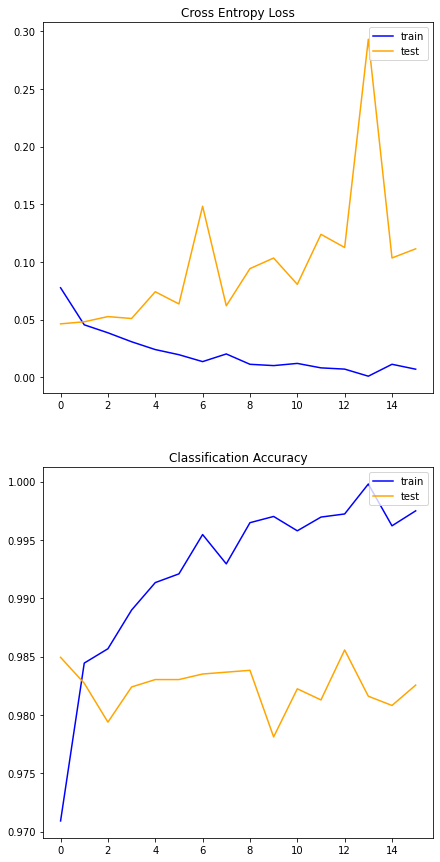

In [8]:
def define_model():
    base_model = ResNet50(include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    # Create fully connected layers on top of the transferred
    # convolutional layers using TensorFlow's functional API.
    top_layers = base_model.output
    top_layers = GlobalAveragePooling2D()(top_layers)

    # 1024 neurons are half the 2048 output dimensionality of the previous
    # layer and the last layer from base ResNet-50.
    top_layers = Dense(units=1024, activation='relu')(top_layers)
    top_layers = Dense(units=512, activation='relu')(top_layers)
    top_layers = Dense(units=256, activation='relu')(top_layers)
    top_layers = Dropout(0.5)(Dense(units=128, activation='relu')(top_layers))
    top_layers = Dense(units=1, activation='sigmoid')(top_layers)

    model = Model(inputs=base_model.input, outputs=top_layers)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

history = run_test_harness()

Below is a code for efficient net B7 and B5. The final accuracy is around 99%.

115277824/115263384 [==============================] - 1s 0us/step
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.
Epoch 1/50
293/293 [==============================] - 205s 652ms/step - loss: 0.0478 - accuracy: 0.9846 - val_loss: 0.0336 - val_accuracy: 0.9887
Epoch 2/50
293/293 [==============================] - 185s 632ms/step - loss: 0.0258 - accuracy: 0.9912 - val_loss: 0.0474 - val_accuracy: 0.9878
Epoch 3/50
293/293 [==============================] - 188s 640ms/step - loss: 0.0186 - accuracy: 0.9936 - val_loss: 0.0458 - val_accuracy: 0.9887
Epoch 4/50
293/293 [==============================] - 186s 635ms/step - loss: 0.0121 - accuracy: 0.9958 - val_loss: 0.0735 - val_accuracy: 0.9862
Epoch 5/50
293/293 [==============================] - 187s 637ms/step - loss: 0.0105 - accuracy: 0.9972 - val_loss: 0.0512 - val_accuracy: 0.9871
Epoch 6/50
293/293 [==============================] - 187s 639ms/step - loss: 0.0105 - accuracy: 0.9971 - val_loss: 0.

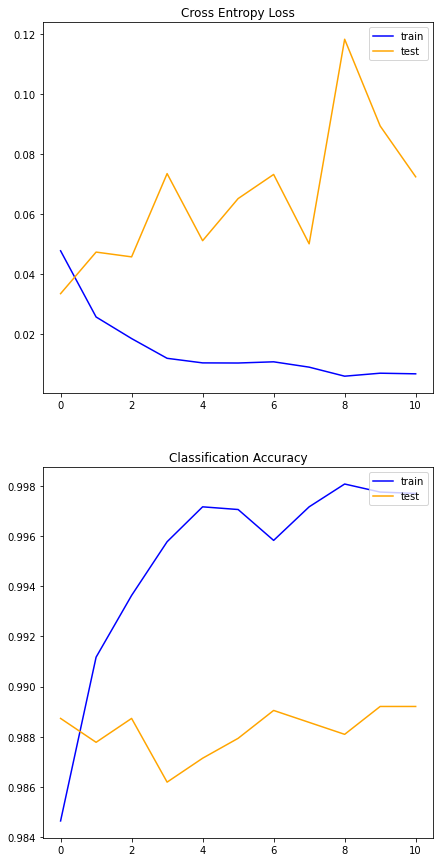

In [9]:
def define_model():
    base_model = EfficientNetB5(include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    # Create fully connected layers on top of the transferred
    # convolutional layers using TensorFlow's functional API.
    top_layers = base_model.output
    top_layers = GlobalAveragePooling2D()(top_layers)

    # 1024 neurons are half the 2048 output dimensionality of the previous
    # layer and the last layer from base ResNet-50.
    top_layers = Dense(units=1024, activation='relu')(top_layers)
    top_layers = Dense(units=512, activation='relu')(top_layers)
    top_layers = Dense(units=256, activation='relu')(top_layers)
    top_layers = Dropout(0.5)(Dense(units=128, activation='relu')(top_layers))
    top_layers = Dense(units=1, activation='sigmoid')(top_layers)

    model = Model(inputs=base_model.input, outputs=top_layers)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

history = run_test_harness()

2022-12-05 02:39:22.173546: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:39:22.174461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:39:22.526751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:39:22.527656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 02:39:22.528404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

258088960/258076736 [==============================] - 1s 0us/step
Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


2022-12-05 02:39:35.932471: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-05 02:39:55.423007: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


293/293 [==============================] - 307s 945ms/step - loss: 0.0512 - accuracy: 0.9854 - val_loss: 0.0232 - val_accuracy: 0.9902
Epoch 2/50
293/293 [==============================] - 278s 948ms/step - loss: 0.0266 - accuracy: 0.9915 - val_loss: 0.0291 - val_accuracy: 0.9897
Epoch 3/50
293/293 [==============================] - 278s 948ms/step - loss: 0.0223 - accuracy: 0.9932 - val_loss: 0.0310 - val_accuracy: 0.9894
Epoch 4/50
293/293 [==============================] - 278s 949ms/step - loss: 0.0167 - accuracy: 0.9946 - val_loss: 0.0288 - val_accuracy: 0.9900
Epoch 5/50
293/293 [==============================] - 278s 950ms/step - loss: 0.0126 - accuracy: 0.9966 - val_loss: 0.0355 - val_accuracy: 0.9913
Epoch 6/50
293/293 [==============================] - 280s 955ms/step - loss: 0.0116 - accuracy: 0.9961 - val_loss: 0.0343 - val_accuracy: 0.9908
Epoch 7/50
293/293 [==============================] - 280s 956ms/step - loss: 0.0108 - accuracy: 0.9968 - val_loss: 0.0442 - val_accura

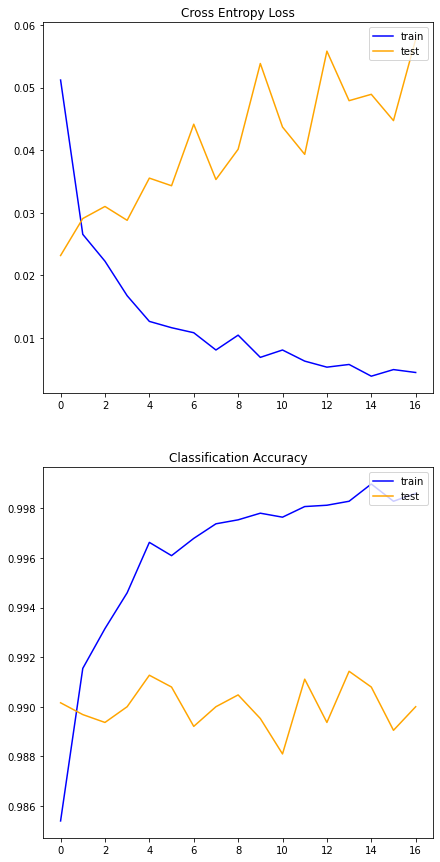

In [6]:
def define_model():
    base_model = EfficientNetB7(include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False
    # Create fully connected layers on top of the transferred
    # convolutional layers using TensorFlow's functional API.
    top_layers = base_model.output
    top_layers = GlobalAveragePooling2D()(top_layers)

    # 1024 neurons are half the 2048 output dimensionality of the previous
    # layer and the last layer from base ResNet-50.
    top_layers = Dense(units=1024, activation='relu')(top_layers)
    top_layers = Dense(units=512, activation='relu')(top_layers)
    top_layers = Dense(units=256, activation='relu')(top_layers)
    top_layers = Dropout(0.5)(Dense(units=128, activation='relu')(top_layers))
    top_layers = Dense(units=1, activation='sigmoid')(top_layers)

    model = Model(inputs=base_model.input, outputs=top_layers)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

history = run_test_harness()

## Final Model

We will now create a final resnet model, fitted on the entire training dataset. We make predictions on the test dataset, and download the results in form of a csv.

In [3]:
# organize dataset into a useful structure

# create directories
dataset_home = '/kaggle/working/sg/final/train/'

# create label subdirectories
labeldirs = ['dogs/', 'cats/']
for labldir in labeldirs:
    newdir = dataset_home + labldir
    makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)

# copy training dataset images into subdirectories
src_directory = '/kaggle/working/train/'
for file in listdir(src_directory):
    src = src_directory + '/' + file
    if file.startswith('cat'):
        dst = dataset_home + 'cats/' + file
        copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_home + 'dogs/' + file
        copyfile(src, dst)

In [10]:
# run the test harness for evaluating a model
#implementing early stopping in this code
def run_test_harness():
# define model
    model = define_model()

    # create data generator
    datagen = ImageDataGenerator()

    # prepare iterator
    train_it = datagen.flow_from_directory('/kaggle/working/sg/final/train/',
                    class_mode='binary', batch_size=64, target_size=(224, 224))

    test_filenames = os.listdir("./test")
    test_df = pd.DataFrame({'filename': test_filenames})

    test_it = datagen.flow_from_dataframe(test_df, "./test", 
            x_col='filename', y_col=None,
            target_size=(224, 224), class_mode=None,
            batch_size=64,
            shuffle=False # not to shuffle the given data
)

    #callback for early stopping
    callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

    # fit model
    history = model.fit(train_it, steps_per_epoch=len(train_it), epochs=8, verbose=1,
                            callbacks=[callback])
    # predict model
    prediction = model.predict(test_it)

    results = pd.DataFrame({"id": test_filenames, "label":list(prediction)})
    results['label'] = results['label'].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)
    results['id'] = results['id'].map(lambda x:int(str(x).split('.')[0]))
    
    return results

In [11]:
def define_model():
    
    img_augmentation = Sequential([
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip()
    ])
    
    inputs = layers.Input(shape=(224, 224, 3))
    inputs = img_augmentation(inputs)
    base_model = EfficientNetB7(include_top=False, input_tensor=inputs, weights="imagenet")
    
    for layer in base_model.layers:
        layer.trainable = False
    # Create fully connected layers on top of the transferred
    # convolutional layers using TensorFlow's functional API.
    top_layers = base_model.output
    top_layers = GlobalAveragePooling2D()(top_layers)
    top_layers = Dense(200, activation='relu')(top_layers)
    top_layers = Dense(units=1, activation='sigmoid')(top_layers)

    model = Model(inputs=base_model.input, outputs=top_layers)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

results = run_test_harness()

Found 25000 images belonging to 2 classes.
Found 12500 validated image filenames.
Epoch 1/8
391/391 [==============================] - 306s 728ms/step - loss: 0.1288 - accuracy: 0.9473
Epoch 2/8
391/391 [==============================] - 283s 723ms/step - loss: 0.1051 - accuracy: 0.9595
Epoch 3/8
391/391 [==============================] - 283s 724ms/step - loss: 0.0957 - accuracy: 0.9618
Epoch 4/8
391/391 [==============================] - 283s 723ms/step - loss: 0.0870 - accuracy: 0.9648
Epoch 5/8
391/391 [==============================] - 283s 723ms/step - loss: 0.0840 - accuracy: 0.9671
Epoch 6/8
391/391 [==============================] - 283s 723ms/step - loss: 0.0801 - accuracy: 0.9682
Epoch 7/8
391/391 [==============================] - 283s 724ms/step - loss: 0.0776 - accuracy: 0.9686
Epoch 8/8
391/391 [==============================] - 283s 722ms/step - loss: 0.0731 - accuracy: 0.9704


In [13]:
results.to_csv('MSBA.Session2023.Shubham_Garg.csv', index=False)

#### Appendix

In [13]:
#code to view individual images

test_dir = '/kaggle/working/train'
test_images = []
test_filenames = []
for img in os.listdir(test_dir):
    try:
        img_r = cv2.imread(os.path.join(test_dir, img), cv2.IMREAD_COLOR)
        test_images.append(np.array(cv2.resize(img_r, (150, 150), interpolation=cv2.INTER_CUBIC)))
        test_filenames.append(img.split('.')[0])
    except Exception as e:
        print('broken image')

test_filenames = [int(a) for a in test_filenames]

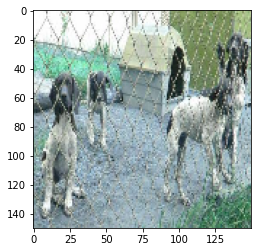

In [17]:
pyplot.imshow(test_images[5336])